# Declaração do Problema

A Análise Exploratória de Dados a seguir tem como o objetivo identificar o perfil dos acidentes rodoviários no Brasil. Quais as principais causas, regiões e rodoviais com maior número de ocorrências, permitindo assim que os responsáveis possam tomar decisões mais assertivas para reduzir a taxa de acidentes nas estradas do país.

# Bibliotecas

In [116]:
#Data Manipulation
import pandas as pd
import numpy as np
import json
import datetime
import calendar

#Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
colors_ref = ['#1d3557', '#457b9d', '#a8dadc', '#e63946', '#f1faee']
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

import seaborn as sns
import folium
import graph

#Script to download data
from dados_acidentes_PRF_downloader import get_dados_acidentes_PRF_BR

import warnings
warnings.filterwarnings(action='ignore')

# Dados

In [117]:
#get_dados_acidentes_PRF_BR(2023)

In [118]:
df = pd.read_csv("data/datatran2023.csv", sep = ";", encoding = 'ISO-8859-1')

print("---------- Dataset ----------")
print("Número de linhas: {}".format(df.shape[0]))
print("Número de colunas: {}".format(df.shape[1]))

df.head()

---------- Dataset ----------
Número de linhas: 38408
Número de colunas: 30


,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496519,2023-01-01,domingo,02:00:00,ES,101.0,114,SOORETAMA,Ausência de reação do condutor,Saída de leito carroçável,...,0,0,0,1,1,"-19,09484877","-40,05095848",SPRF-ES,DEL04-ES,UOP01-DEL04-ES
1,496543,2023-01-01,domingo,03:40:00,SP,116.0,"113,1",TAUBATE,Entrada inopinada do pedestre,Atropelamento de Pedestre,...,0,0,4,0,1,"-23,0445658","-45,58259814",SPRF-SP,DEL02-SP,UOP02-DEL02-SP
2,496590,2023-01-01,domingo,01:40:00,MT,163.0,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Tombamento,...,1,0,0,1,1,"-9,70020602","-54,87588757",SPRF-MT,DEL06-MT,UOP03-DEL06-MT
3,496610,2023-01-01,domingo,10:40:00,PR,376.0,"314,8",ORTIGUEIRA,Velocidade Incompatível,Tombamento,...,0,1,0,0,1,"-23,985512","-51,083555",SPRF-PR,DEL07-PR,UOP02-DEL07-PR
4,496659,2023-01-01,domingo,14:55:00,MG,116.0,"569,4",MANHUACU,Acumulo de água sobre o pavimento,Colisão frontal,...,2,1,0,2,2,"-20,10007457","-42,17884091",SPRF-MG,DEL06-MG,UOP03-DEL06-MG


# Análise Exploratória dos Dados 

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38408 entries, 0 to 38407
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38408 non-null  int64  
 1   data_inversa            38408 non-null  object 
 2   dia_semana              38408 non-null  object 
 3   horario                 38408 non-null  object 
 4   uf                      38408 non-null  object 
 5   br                      38316 non-null  float64
 6   km                      38316 non-null  object 
 7   municipio               38408 non-null  object 
 8   causa_acidente          38408 non-null  object 
 9   tipo_acidente           38408 non-null  object 
 10  classificacao_acidente  38408 non-null  object 
 11  fase_dia                38408 non-null  object 
 12  sentido_via             38408 non-null  object 
 13  condicao_metereologica  38408 non-null  object 
 14  tipo_pista              38408 non-null

In [120]:
def alterar_df(df):
    br_concessao = ['BR-381/MG', 'BR-381/SP', 
                 'BR-101/RJ', 
                 'BR-376/PR', 'BR-101/SC',
                 'BR-116/PR', 'BR-116/SC', 
                 'BR-116/SP', 'BR-116/PR', 
                 'BR-060/DF', 'BR-060/GO', 'BR-060/MG', 
                 'BR-153/DF', 'BR-153/GO', 'BR-153/MG', 
                 'BR-262/DF', 'BR-262/GO', 'BR-262/MG', 
                 'BR-040/MG', 'BR-040/RJ', 
                 'BR-116/RJ', 
                 'BR-101/ES', 'BR-101/BA', 
                 'BR-101/RJ', 
                 'BR-116/RS', 'BR-293/RS', 
                 'BR-050/GO', 'BR-050/MG', 
                 'BR-163/MS', 
                 'BR-116/RJ', 'BR-116/SP', 
                 'BR-393/RJ', 
                 'BR-163/MT', 
                 'BR-153/SP', 
                 'BR-040/DF', 'BR-040/GO', 'BR-040/MG', 
                 'BR-116/BA', 'BR-324/BA', 
                 'BR-101/RS', 'BR-290/RS', 'BR-386/RS', 'BR-448/RS']
    
    df_alterado = df.copy()
    df_alterado.rename(columns = {"data_inversa":"data"}, inplace = True)

    df_alterado['data'] = pd.to_datetime(df_alterado['data'], format = "%Y-%m-%d")
    df_alterado['horario'] = pd.to_datetime(df['horario'], format = "%H:%M:%S")
    
    df_alterado['dia_semana'] = df_alterado['data'].apply(lambda x: x.strftime('%w'))
    
    df_alterado["latitude"] = df_alterado["latitude"].str.replace(',','.').astype(float)
    df_alterado["longitude"] = df_alterado["longitude"].str.replace(',','.').astype(float)
    
    df_alterado.dropna(inplace=True)
    
    df_alterado["br"] = df_alterado["br"].apply(lambda x: str(round(x)))
    
    df_alterado["br_loc"] = "BR-" + df_alterado["br"] + "/" + df_alterado["uf"]
    df_alterado["concessoes"] = df_alterado["br_loc"].apply(lambda x: "privada" if x in br_concessao else "publica" )
    
    df_alterado["municipio"] =  df_alterado["municipio"] + "/" + df_alterado["uf"]

    return df_alterado

In [121]:
df_alterado = alterar_df(df)

In [122]:
def gerar_metadata(df):
    
    metadata = pd.DataFrame({
        'nome_variavel': df.columns,
        'tipo': df.dtypes,
        'qt_nulos' : df.isnull().sum(),
        'percent_nulos' : round((df.isnull().sum() / len(df))* 100,2),
        'cardinalidade': df.nunique(),    
    })
    
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)
    
    return metadata

In [123]:
metadata_df = gerar_metadata(df_alterado)
display(metadata_df)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,id,int64,0,0.0,37969
1,data,datetime64[ns],0,0.0,212
2,horario,datetime64[ns],0,0.0,1331
3,veiculos,int64,0,0.0,13
4,feridos,int64,0,0.0,30
5,ignorados,int64,0,0.0,10
6,ilesos,int64,0,0.0,45
7,feridos_graves,int64,0,0.0,14
8,feridos_leves,int64,0,0.0,26
9,mortos,int64,0,0.0,8


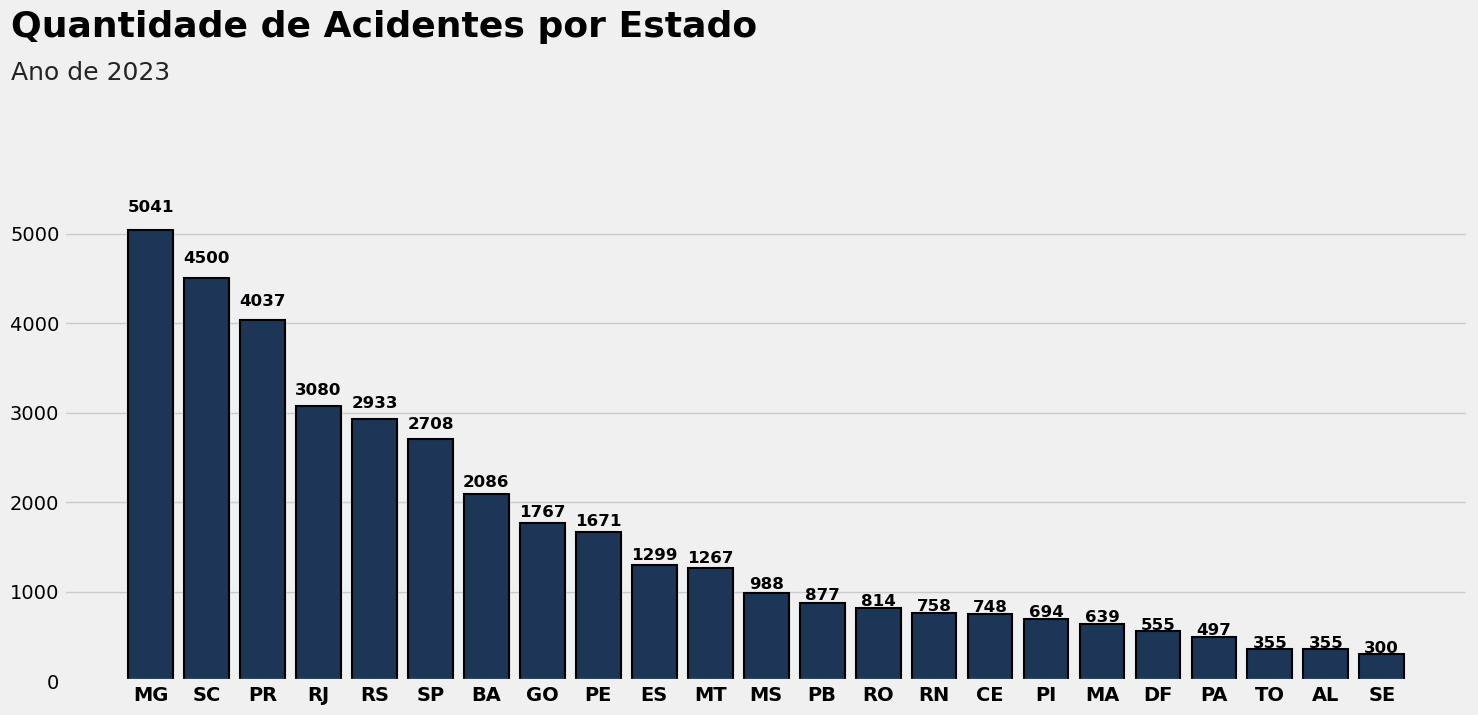

In [124]:
height = df_alterado['uf'].value_counts().values
estados = df_alterado['uf'].value_counts().index

graph.plot_bar(estados, height,
         titulo = 'Quantidade de Acidentes por Estado', subtitulo = "Ano de 2023", 
         titulo_x_pos = -2.5);

In [127]:
municipio = df_alterado["municipio"].value_counts().sort_values(ascending=True).tail(15).index
width = df_alterado["municipio"].value_counts().sort_values(ascending=True).tail(15).values

graph.plot_hbar(municipio, width,
                titulo = 'Quantidade de Acidentes por Cidade', subtitulo = "Ano de 2023",
                titulo_x_pos = -130, titulo_y_pos = 15, 
                height = 0.5, 
                total = df_alterado["municipio"].value_counts().sort_values(ascending=True).values);

TypeError: plot_hbar() got an unexpected keyword argument 'total'

In [ ]:
tipo_administracao = df_alterado["concessoes"].value_counts().index
width = df_alterado["concessoes"].value_counts().values

graph.plot_hbar(tipo_administracao, width,
         titulo = 'Quantidade de Acidentes por Tipo de Administração', subtitulo = "Ano de 2023",
         y_labels = ['Pública', 'Privada'],
         colors = ['#457b9d', '#1d3557'],
         titulo_x_pos = -1500, titulo_y_pos = 1.6, 
         height = 0.5);

In [ ]:
rodovias = df_alterado[['br_loc', 'concessoes']].value_counts().index.get_level_values('br_loc')[:16]
height = df_alterado[['br_loc', 'concessoes']].value_counts().values[:16]
labels = df_alterado[['br_loc', 'concessoes']].value_counts().index.get_level_values('concessoes')[:16]
colors = [colors_ref[0] if t == "privada" else colors_ref[1] for t in labels]
legend = ['Privada', '_privada', '_privada', 'Pública', '_privada', '_privada',
       '_publica', '_privada', '_privada', '_publica', '_privada', '_publica',
       '_publica', '_publica', '_publica', '_privada']

graph.plot_bar(rodovias, height, 
         titulo = 'Rodovias com o Maior Número de Acidentes', subtitulo = "Ano de 2023", 
         colors = colors, rotation = 90, legend = legend);

In [ ]:
height = df_alterado['data'].dt.month.value_counts().sort_index().values
meses = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho"]

graph.plot_bar(meses, height,
         titulo = 'Quantidade de Acidentes por Mês', subtitulo = "Ano de 2023", 
         titulo_x_pos = -1);

In [ ]:
height = df_alterado['data'].dt.weekday.value_counts().sort_index().values
dias_semana = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado', 'domingo']

graph.plot_bar(dias_semana, height,
         titulo = 'Quantidade de Acidentes por Dia da Semana', subtitulo = "Ano de 2023", 
         titulo_x_pos = -1);

In [ ]:
height = df_alterado['horario'].dt.hour.value_counts().sort_index().values
horas = [(str(hour) + ":00") if hour > 10 else ("0" + str(hour) + ":00") for hour in range(0,24)]

graph.plot_bar(horas, height,
         titulo = 'Quantidade de Acidentes por Hora', subtitulo = "Ano de 2023", 
         titulo_x_pos = -2.5, rotation = 90);

In [ ]:
width = df_alterado['classificacao_acidente'].value_counts().sort_values(ascending=True).values
classificacao_acidente = df_alterado['classificacao_acidente'].value_counts().sort_values(ascending=True).index

graph.plot_hbar(classificacao_acidente, width,
         titulo = 'Quantidade de Acidentes por Classificação do Acidente', subtitulo = "Ano de 2023",
         colors = colors_ref,
         titulo_x_pos = -5400, titulo_y_pos = 2.3, 
         height = 0.6);

In [ ]:
width = df_alterado['causa_acidente'].value_counts().head(10).sort_values().values
causas_acidentes = df_alterado['causa_acidente'].value_counts().head(10).sort_values().index

graph.plot_hbar(causas_acidentes, width,
                 titulo = 'Principais Causas de Acidentes', subtitulo = "Ano de 2023",
                 titulo_x_pos = -3000, titulo_y_pos = 9.5, 
                 colors = colors_ref[0],
                 height = 0.6,
                 width_size = 20);

In [ ]:
width = df_alterado['tipo_acidente'].value_counts().head(10).sort_values().values
causas_acidentes = df_alterado['tipo_acidente'].value_counts().head(10).sort_values().index

graph.plot_hbar(causas_acidentes, width,
         titulo = 'Principais Tipos de Acidentes', subtitulo = "Ano de 2023",
         titulo_x_pos = -2000, titulo_y_pos = 9.5, 
         colors = colors_ref[3],
         height = 0.6);

In [ ]:
tipo_pista = df_alterado['fase_dia'].value_counts().sort_values(ascending=True).index[:16]
dict_tipo_pista = df_alterado.groupby('fase_dia').sum().to_dict()
stacks = ['ilesos','feridos_leves', 'feridos_graves', 'mortos']

dict_stacks = {key: [dict_tipo_pista[key][k] for k in tipo_pista] for key in stacks}

graph.plot_stacked_barh(tipo_pista, dict_stacks, 
                 titulo = 'Quantidade de Acidentes por Fase do Dia', subtitulo = "Ano de 2023", 
                 titulo_x_pos = -4500, titulo_y_pos = 3.5, 
                 colors = ['#1d3557', '#457b9d', '#a8dadc', '#e63946'],
                 height = 0.5)

In [ ]:
tipo_pista = df_alterado['tipo_pista'].value_counts().sort_values(ascending=True).index
dict_tipo_pista = df_alterado.groupby('tipo_pista').sum().to_dict()
stacks = ['ilesos','feridos_leves', 'feridos_graves', 'mortos']

dict_stacks = {key: [dict_tipo_pista[key][k] for k in tipo_pista] for key in stacks}

graph.plot_stacked_barh(tipo_pista, dict_stacks, 
                 titulo = 'Quantidade de Acidentes por Tipo de Pista', subtitulo = "Ano de 2023", 
                 titulo_x_pos = -3000, titulo_y_pos = 2.5, 
                 colors = ['#1d3557', '#457b9d', '#a8dadc', '#e63946'],
                 legend = ['Ilesos','Feridos Leves', 'Feridos Graves', 'Mortos'],
                 height = 0.5)

In [ ]:
tipo_pista = df_alterado['tracado_via'].value_counts().sort_values(ascending=True).index
dict_tipo_pista = df_alterado.groupby('tracado_via').sum().to_dict()
stacks = ['ilesos','feridos_leves', 'feridos_graves', 'mortos']

dict_stacks = {key: [dict_tipo_pista[key][k] for k in tipo_pista] for key in stacks}

graph.plot_stacked_barh(tipo_pista, dict_stacks, 
                 titulo = 'Quantidade de Acidentes por Traçado da Via', subtitulo = "Ano de 2023", 
                 titulo_x_pos = -12000, titulo_y_pos = 9, 
                 colors = ['#1d3557', '#457b9d', '#a8dadc', '#e63946'],
                 legend = ['Ilesos','Feridos Leves', 'Feridos Graves', 'Mortos'],
                 height = 0.6)

In [ ]:
df_AcidentesEstado = pd.DataFrame({
    "UF":df["uf"].value_counts().index, 
    "Acidentes":df["uf"].value_counts().values
})

map = folium.Map(
        location=[-15, -50], 
        zoom_start=4,
        width=900, 
        height=800
)

folium.Choropleth(
    geo_data = "brazil_geo.json", 
    name = "choropleth",
    data = df_AcidentesEstado,
    columns = ["UF", "Acidentes"],
    popup = ['mortos'],
    key_on = "feature.id",
    fill_color="Blues",
    fill_opacity = 0.7,
    legend_name = "Número de Acidentes"
).add_to(map)


map